## Predictions with Rules dataset

In [3]:
import pandas as pd
import numpy as np

### Load data

In [4]:
df_orig = pd.read_csv('Shopping_tabular.txt', delimiter=';')
dfrules = pd.read_excel('Rules.xlsx')

X = df_orig.values
array = np.arange(X.shape[1])
dfrules.sort_values(['antecedents', 'confidence'], ascending=[True, False], inplace=True)

# Map products and remove TICKET
df_Predictions=df_orig*array
mapping = {idx: item for idx, item in enumerate(df_orig.columns)}
df_Predictions=df_Predictions.apply(lambda x: [mapping[i] for i in x])
df_Predictions.replace(to_replace=['TICKET'],value='',inplace=True)
products=list(df_Predictions.columns.values)
products.remove('TICKET')
del df_Predictions['TICKET']

In [5]:
# store list of products purchased
df_Predictions['products'] = df_Predictions[products].apply(
    lambda row: [item for item in products if len(row[item]) > 0], axis=1
)

# convert antecedents information into a list 
dfrules['listantec'] = dfrules['antecedents'].apply(
    lambda x: x.split(',') if isinstance(x, str) else []
)

### Searches in antecedents list, for elements contained in products

In [6]:
df_Predictions['predrule']=''
df_Predictions['predconf']=''
df_Predictions['predruleid']=''

for index, row in df_Predictions.iterrows():
    storerule = []
    lstproducts = row['products']  # list of products purchased

    for _, rule in dfrules.iterrows():
        lstantec = rule['listantec'] 
        conseq = rule['consequent']  

        # Check if all antecedents are in products and the consequent is not
        if all(item in lstproducts for item in lstantec) and conseq not in lstproducts:
            storerule.append([
                rule['ruleid'],  
                rule['consequent'],  
                round(rule['confidence'], 3)  
            ])

### Search rules and assign predictions

In [7]:
# Convert data to efficient structures
products_list = df_Predictions['products'].tolist()
rules = dfrules[['listantec', 'consequent', 'confidence', 'ruleid']].to_dict(orient='records')

predictions = []
for lstproducts in products_list:
    best_rule = {'consequent': '', 'confidence': 0, 'ruleid': ''}
    for rule in rules:
        lstantec = rule['listantec']
        conseq = rule['consequent']
        conf = rule['confidence']
        # Check if the antecedents are fulfilled and the consequent is not in the list of products.
        if all(item in lstproducts for item in lstantec) and conseq not in lstproducts:
            if conf > best_rule['confidence']:
                best_rule = {
                    'consequent': conseq,
                    'confidence': conf,
                    'ruleid': rule['ruleid'] - 1 if isinstance(rule['ruleid'], int) else int(rule['ruleid']) - 1
                }
    predictions.append(best_rule)

# Assign preductions to the dataframe
df_Predictions['predrule'] = [pred['consequent'] for pred in predictions]
df_Predictions['predconf'] = [pred['confidence'] if 'confidence' in pred and pred['confidence'] else np.nan for pred in predictions]
df_Predictions['predruleid'] = [pred['ruleid'] for pred in predictions]

# Remove temporary columns
df_Predictions.drop(columns=['products'] + products, inplace=True)

In [8]:
# Add predictions to original file and display it
df_Predictions=pd.concat([df_orig, df_Predictions], axis=1)
df_Predictions

,TICKET,Alcohol,Bakery goods,Fresh Vegetables,Fresh meat,Frozen foods,Milk,Ready made,Snacks,Tinned Goods,Toiletries,predrule,predconf,predruleid
0,1,0,0,0,0,0,0,1,1,0,0,,NaN,
1,2,0,0,0,0,0,0,1,0,0,1,,NaN,
2,3,0,0,0,0,0,0,1,1,0,1,,NaN,
3,4,0,1,0,0,0,1,1,0,0,0,,NaN,
4,5,0,0,0,0,0,0,1,0,0,0,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,782,1,0,0,0,0,0,0,0,0,0,,NaN,
782,783,0,1,0,0,1,0,1,1,0,0,,NaN,
783,784,1,0,0,0,0,0,0,0,0,0,,NaN,
784,785,1,0,0,0,1,0,0,1,0,0,,NaN,


In [9]:
df_Predictions.to_excel("Predictions.xlsx")
df_Predictions

,TICKET,Alcohol,Bakery goods,Fresh Vegetables,Fresh meat,Frozen foods,Milk,Ready made,Snacks,Tinned Goods,Toiletries,predrule,predconf,predruleid
0,1,0,0,0,0,0,0,1,1,0,0,,NaN,
1,2,0,0,0,0,0,0,1,0,0,1,,NaN,
2,3,0,0,0,0,0,0,1,1,0,1,,NaN,
3,4,0,1,0,0,0,1,1,0,0,0,,NaN,
4,5,0,0,0,0,0,0,1,0,0,0,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,782,1,0,0,0,0,0,0,0,0,0,,NaN,
782,783,0,1,0,0,1,0,1,1,0,0,,NaN,
783,784,1,0,0,0,0,0,0,0,0,0,,NaN,
784,785,1,0,0,0,1,0,0,1,0,0,,NaN,


### We now integrate predictions with rules and demographic information in a single dataframe

In [10]:
df_merged = pd.merge(df_Predictions, dfrules, left_on='predruleid', right_on='ruleid', how='inner')
df_merged=df_merged.drop(["Unnamed: 0", "ruleid"], axis=1)

In [11]:
df_demog = pd.read_csv('Shopping_demographics.txt')
df_demog

,CUSTOMER,GENDER,AGE RANGE,MARITAL,CHILDREN,WORKING
0,1,Female,18 to 30,Widowed,No,Yes
1,2,Female,18 to 30,Separated,No,Yes
2,3,Male,18 to 30,Single,No,Yes
3,4,Female,18 to 30,Widowed,No,Yes
4,5,Female,18 to 30,Separated,No,Yes
...,...,...,...,...,...,...
781,782,Male,18 to 30,Single,No,Yes
782,783,Male,18 to 30,Single,No,Yes
783,784,Male,18 to 30,Single,No,Yes
784,785,Male,18 to 30,Single,No,Yes


In [12]:
df_merged = pd.merge(df_merged, df_demog, left_on='TICKET', right_on='CUSTOMER', how='inner')
df_merged=df_merged.drop("CUSTOMER", axis=1)
df_merged.to_excel("All merged.xlsx")
df_merged

,TICKET,Alcohol,Bakery goods,Fresh Vegetables,Fresh meat,Frozen foods,Milk,Ready made,Snacks,Tinned Goods,...,conf.difference,conf.ratio,#antec,#conseq,listantec,GENDER,AGE RANGE,MARITAL,CHILDREN,WORKING
0,135,0,0,0,1,1,0,1,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Female,18 to 30,Separated,No,Yes
1,186,0,0,0,0,1,0,1,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Male,Over 60,Divorced,Yes,Yes
2,257,0,0,0,0,1,0,0,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Male,51 to 60,Divorced,Yes,No
3,300,0,0,0,0,1,0,1,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Female,51 to 60,Married,No,Yes
4,393,1,0,0,0,1,0,0,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Female,31 to 40,Single,No,Yes
5,515,1,0,1,0,1,0,0,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Male,18 to 30,Widowed,No,Yes
6,563,0,0,0,0,1,0,1,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Male,31 to 40,Separated,Yes,Yes
7,634,1,0,0,0,1,0,0,1,1,...,0.322067,0.395449,3,1,"[Tinned Goods, Alcohol, Bakery goods]",Male,51 to 60,Divorced,No,Yes
8,145,1,0,0,0,1,0,1,1,1,...,0.406541,0.486704,2,1,"[Frozen foods, Milk]",Female,Over 60,Married,No,Yes
9,158,1,0,0,0,0,0,1,0,1,...,0.406541,0.486704,2,1,"[Frozen foods, Milk]",Male,51 to 60,Widowed,No,Yes


### And finally some charts to find out any specific relation between demographic group and consequents

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def barchart(var1, var2): # var1 stores the consequent of the prediction & var2 the demographic variable
    frequencies = pd.crosstab(df_merged[var1], df_merged[var2])
    frequencies_normalized = frequencies.div(frequencies.sum(axis=1), axis=0) * 100
    
    fig, ax = plt.subplots(figsize=(10, 6))

    bottom_values = np.zeros(len(frequencies_normalized)) 
    for col in frequencies_normalized.columns:
        ax.bar(
            frequencies_normalized.index,
            frequencies_normalized[col],
            bottom=bottom_values,
            label=col
        )
        bottom_values += frequencies_normalized[col]
    
    ax.set_ylabel('Frequency (%)')
    ax.set_title('Clustered bar chart')
    ax.set_yticks(np.arange(0, 111, 10))
    ax.legend(title=var2, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

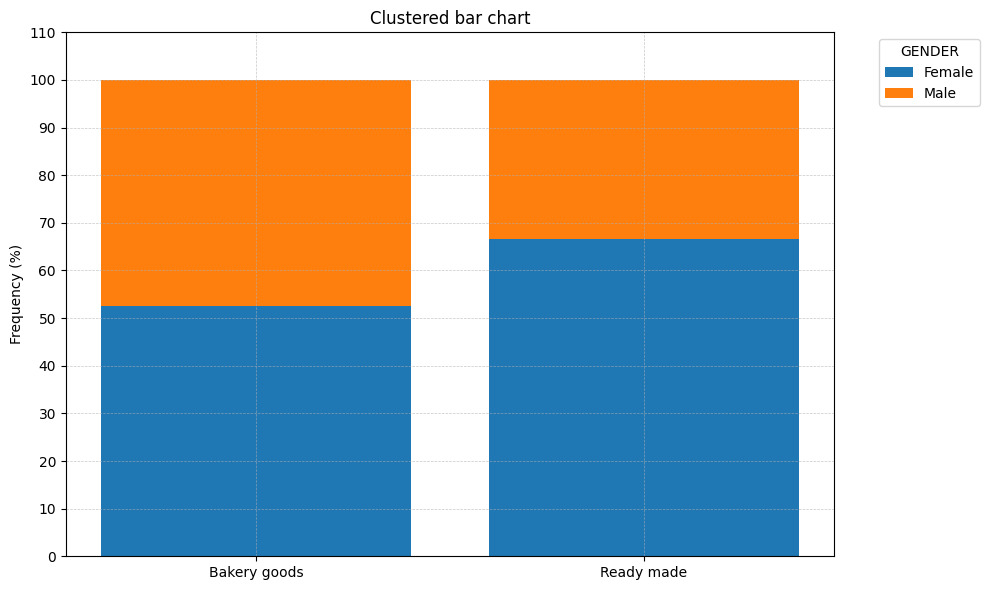

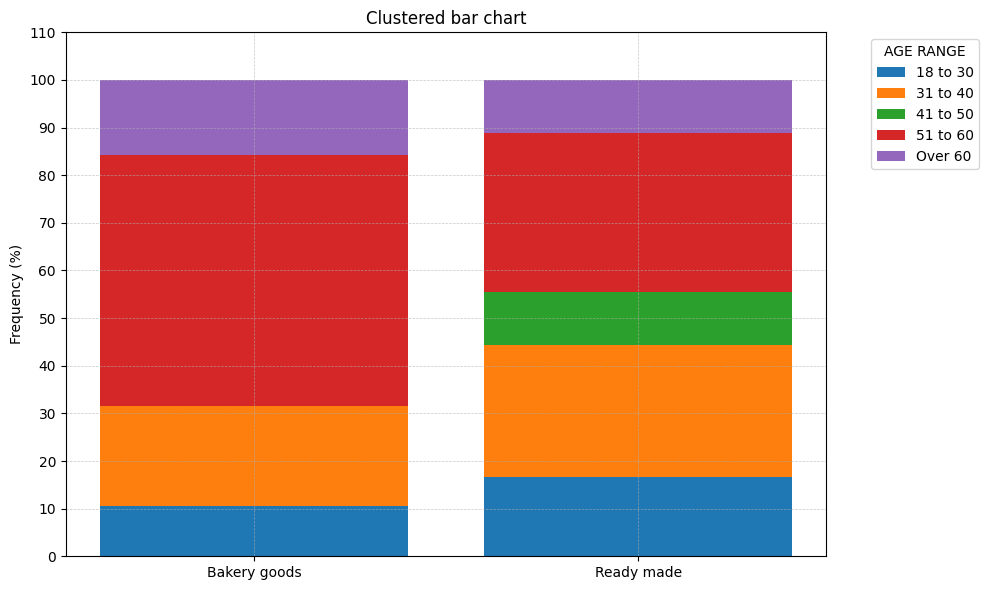

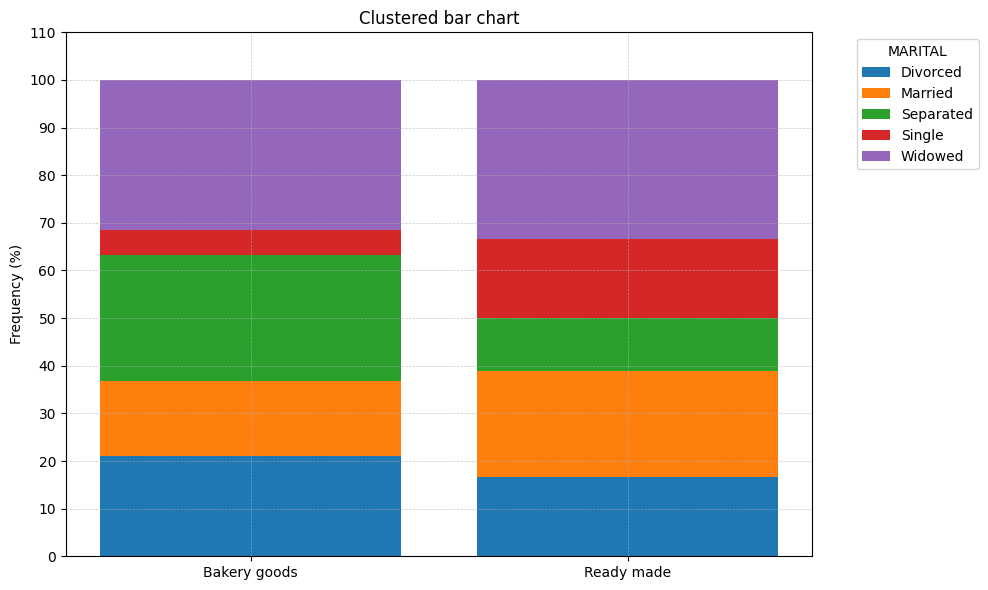

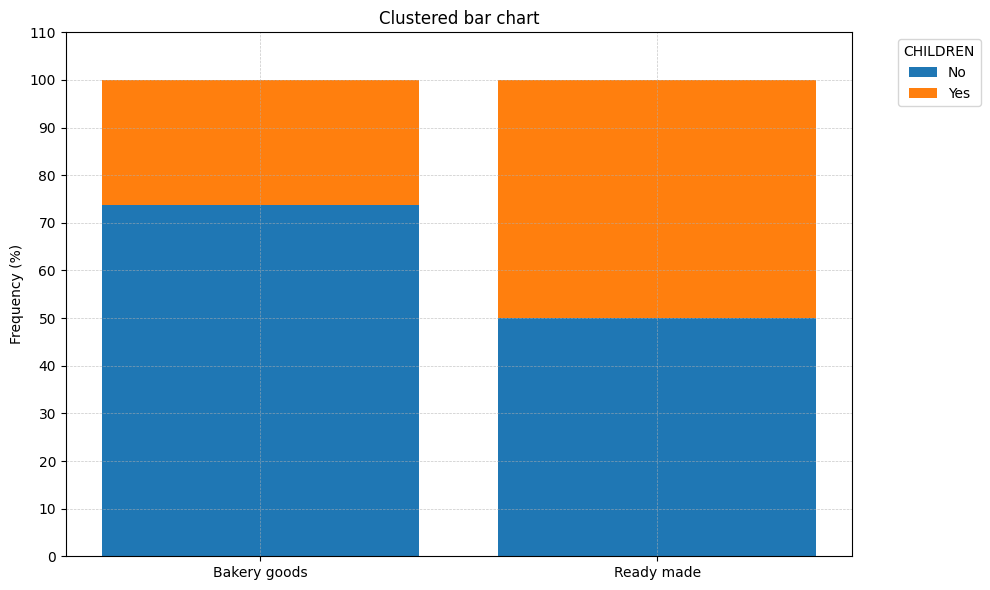

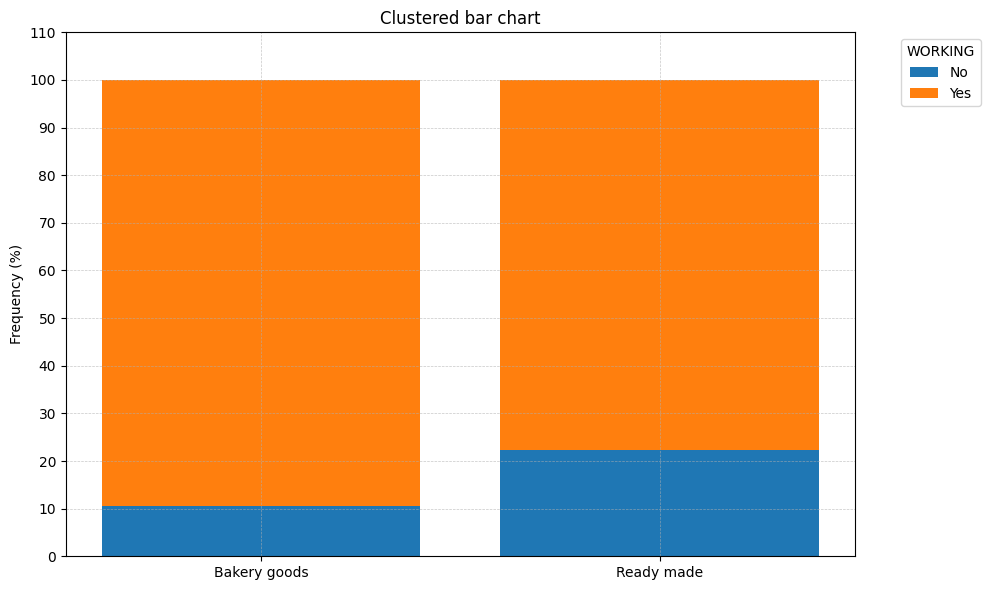

In [14]:
for col in df_demog.columns:
    unique_vals = df_demog[col].nunique() 
    if unique_vals <= 15: # barchart only on categorical variables
        barchart("predrule", col)